# Test OBI Code
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
from batchbald_redux import online_bayesian_inference
import torch

In [ ]:
exp1 = torch.distributions.Exponential(1)

In [ ]:
log_probs=torch.log(1+exp1.sample_n(100000))

In [ ]:
torch.sum(log_probs), torch.sum(log_probs.double()).float(), online_bayesian_inference.sum_log_probs(log_probs, dim=0)

(tensor(59585.6602), tensor(59585.6641), tensor(59585.6641))

In [ ]:
log_probs = torch.log(torch.rand(10000))
log_probs

tensor([-0.0147, -0.9602, -0.4252,  ..., -0.1417, -2.7528, -2.2379])

In [ ]:
torch.sum(log_probs), torch.sum(log_probs.double())

(tensor(-10135.6260), tensor(-10135.6260, dtype=torch.float64))

# Retrain to 90% with 55 samples

In [ ]:
# Rerun from 2022/04/15

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    17776,
    36852,
    26891,
    17001,
    44414,
    23050,
    30884,
    41516,
    8897,
    34608,
    11721,
    13127,
    9870,
    39700,
    13985,
    9608,
    17808,
    23028,
    3494,
    10210,
    42384,
    31742,
    17100,
    46530,
    26733,
    4762,
    14113,
    20798,
    28388,
    42973,
    37347,
    55042,
    41295,
    28310,
    19280,
    18501,
    274,
    11208,
    13335,
    24440,
    49493,
    58129,
    56210,
    40766,
    13318,
    50040,
    18408,
    7255,
    15494,
    7168,
    9472,
    14845,
    14096,
    26072,
    35944,
    34836,
    12655,
    991,
    38577,
    47322,
    45212,
    16286,
    5308,
    38182,
    31624,
    12702,
    30861,
    46320,
    36408,
    49841,
    33426,
    57527,
    3273,
    24740,
    39627,
    22199,
    19362,
    42136,
    41965,
    43095,
]

training_set_90[:20] = [51348,
 49110,
 8222,
 28130,
 13484,
 47685,
 3938,
 59930,
 49196,
 19427,
 4601,
 49922,
 45635,
 35684,
 3579,
 7621,
 8465,
 33959,
 27521,
 27015]

In [ ]:
# Extracted from stored, old results

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    2748,
    34,
    8009,
    27203,
    54180,
    39513,
    45801,
    34608,
    57338,
    37095,
    5474,
    7304,
    13153,
    4820,
    49406,
    7865,
    7863,
    42303,
    2942,
    52175,
    57842,
    9472,
    16908,
    12585,
    29130,
    29839,
    49509,
    6947,
    18501,
    12422,
    3742,
    19362,
    43169,
    44202,
    22497,
]

training_set_90[:20] = [51348,
 49110,
 8222,
 28130,
 13484,
 47685,
 3938,
 59930,
 49196,
 19427,
 4601,
 49922,
 45635,
 35684,
 3579,
 7621,
 8465,
 33959,
 27521,
 27015]

In [ ]:
import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_challenges import (
    AdditiveGaussianNoise,
    NamedDataset,
    create_repeated_MNIST_dataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory

In [ ]:
# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedBayesianModel

In [ ]:
from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=device), "FastMNIST (train)"
        )
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=device)
# train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

allowed_indices = torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy()
allowed_train_dataset = train_dataset.subset(allowed_indices)
fixed_initial_set_indices = [
    allowed_train_dataset.get_base_dataset_index(i).index for i in training_set_90[:20]
]
fixed_initial_set_indices


NameError: name 'device' is not defined

In [ ]:
@dataclass
class Experiment:
    seed: int = 1337
    training_set_size: int = 35
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    initial_training_set_size: int = 20
    min_samples_per_epoch: int = 1024    
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    
    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )
        #train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=self.device)
        # train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

#         train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

#         allowed_indices = torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy()
#         allowed_train_dataset = train_dataset.subset(allowed_indices)
#         fixed_initial_set_indices = [
#             allowed_train_dataset.get_base_dataset_index(i).index for i in training_set_90[:20]
#         ]

        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire_base_indices(training_set_90[:self.training_set_size])

        active_learning_data_validation_set = ActiveLearningData(train_dataset)
        active_learning_data_validation_set.acquire_base_indices(training_set_90)

        validation_dataset = active_learning_data_validation_set.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=self.device)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, training_set_90[:20]

    def run(self, store):
        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=64,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )
        pool_loader = torch.utils.data.DataLoader(
            active_learning_data.pool_dataset, batch_size=128, drop_last=False, shuffle=False
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        training_set_size = len(active_learning_data.training_dataset)
        print(f"Training set size {training_set_size}:")

        # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
        active_learning_steps.append({})
        iteration_log = active_learning_steps[-1]

        iteration_log["training"] = {}

        model_optimizer = self.model_optimizer_factory().create_model_optimizer()

        double_snapshots = None
        if training_set_size > 0:
            train(
                model=model_optimizer.model,
                optimizer=model_optimizer.optimizer,
                training_samples=self.num_training_samples,
                validation_samples=self.num_validation_samples,
                train_loader=train_loader,
                validation_loader=validation_loader,
                patience=self.num_patience_epochs,
                max_epochs=self.max_training_epochs,
                device=self.device,
                training_log=iteration_log["training"],
                wandb_key_path="",
            )

        evaluation_metrics = evaluate_old(
            model=model_optimizer.model,
            num_samples=self.num_validation_samples,
            loader=test_loader,
            device=self.device,
        )
        iteration_log["evaluation_metrics"] = evaluation_metrics
        print(f"Perf after training {evaluation_metrics}")
        return model_optimizer.model

In [ ]:
experiment = Experiment(
    seed=7,
    training_set_size=25,
    num_pool_samples=100,
    device="cuda",
)

In [ ]:
import dataclasses

In [ ]:
logs = {}
model35 = dataclasses.replace(experiment, training_set_size=35).run(logs)
logs

Training set size 35:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.447265625, 'crossentropy': 1.9910835027694702}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6103515625, 'crossentropy': 1.2986295223236084}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.716796875, 'crossentropy': 0.9267570972442627}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7265625, 'crossentropy': 0.876323401927948}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7216796875, 'crossentropy': 0.8672223687171936}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.75390625, 'crossentropy': 0.7793159484863281}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7646484375, 'crossentropy': 0.7471761107444763}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.734375, 'crossentropy': 0.8230096697807312}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7412109375, 'crossentropy': 0.8189630508422852}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7705078125, 'crossentropy': 0.7629503607749939}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.755859375, 'crossentropy': 0.7886953949928284}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7265625, 'crossentropy': 0.8610079288482666}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.78125, 'crossentropy': 0.7178570628166199}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.767578125, 'crossentropy': 0.7405175566673279}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.734375, 'crossentropy': 0.8230465650558472}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7578125, 'crossentropy': 0.7819514870643616}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.763671875, 'crossentropy': 0.770061194896698}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.74609375, 'crossentropy': 0.8162933588027954}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7470703125, 'crossentropy': 0.7772052884101868}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.76953125, 'crossentropy': 0.7139804363250732}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.759765625, 'crossentropy': 0.7514800429344177}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7314453125, 'crossentropy': 0.8474382162094116}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7333984375, 'crossentropy': 0.815249502658844}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.736328125, 'crossentropy': 0.8011304140090942}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7529296875, 'crossentropy': 0.7968822121620178}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.755859375, 'crossentropy': 0.7825013995170593}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 0.9462878704071045}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.75390625, 'crossentropy': 0.7403719425201416}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.78515625, 'crossentropy': 0.6685580015182495}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7802734375, 'crossentropy': 0.7465391159057617}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7802734375, 'crossentropy': 0.6869835257530212}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7744140625, 'crossentropy': 0.741175651550293}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7724609375, 'crossentropy': 0.7456239461898804}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.767578125, 'crossentropy': 0.75748610496521}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7607421875, 'crossentropy': 0.7913416028022766}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.767578125, 'crossentropy': 0.7609843015670776}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7548828125, 'crossentropy': 0.7689855694770813}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.76953125, 'crossentropy': 0.7237609028816223}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7509765625, 'crossentropy': 0.7683805227279663}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7607421875, 'crossentropy': 0.7895317077636719}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.767578125, 'crossentropy': 0.7206978797912598}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.76953125, 'crossentropy': 0.7057973146438599}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.771484375, 'crossentropy': 0.7348682284355164}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.775390625, 'crossentropy': 0.7193517088890076}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.779296875, 'crossentropy': 0.7332012057304382}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7919921875, 'crossentropy': 0.6962171196937561}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.767578125, 'crossentropy': 0.7840267419815063}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7626953125, 'crossentropy': 0.7877050042152405}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7783203125, 'crossentropy': 0.8014097213745117}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7880859375, 'crossentropy': 0.7389960289001465}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7998046875, 'crossentropy': 0.6840416193008423}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7861328125, 'crossentropy': 0.7265982627868652}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7880859375, 'crossentropy': 0.7080038785934448}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.791015625, 'crossentropy': 0.6998908519744873}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7734375, 'crossentropy': 0.7350669503211975}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.771484375, 'crossentropy': 0.7618177533149719}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.78515625, 'crossentropy': 0.7057140469551086}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.783203125, 'crossentropy': 0.6905902028083801}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7880859375, 'crossentropy': 0.6884310245513916}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7890625, 'crossentropy': 0.7025330066680908}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7763671875, 'crossentropy': 0.7102656960487366}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7880859375, 'crossentropy': 0.7015531659126282}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7861328125, 'crossentropy': 0.719842791557312}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7822265625, 'crossentropy': 0.7448790669441223}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7626953125, 'crossentropy': 0.7195961475372314}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7666015625, 'crossentropy': 0.7432304620742798}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7802734375, 'crossentropy': 0.7493838667869568}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7578125, 'crossentropy': 0.7286192178726196}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.787109375, 'crossentropy': 0.702856719493866}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7666015625, 'crossentropy': 0.7778734564781189}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.802734375, 'crossentropy': 0.7017546892166138}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.80078125, 'crossentropy': 0.7095827460289001}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7744140625, 'crossentropy': 0.801038384437561}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7802734375, 'crossentropy': 0.6882880330085754}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7783203125, 'crossentropy': 0.7073860168457031}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7744140625, 'crossentropy': 0.7603689432144165}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7568359375, 'crossentropy': 0.7915321588516235}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7685546875, 'crossentropy': 0.7087028622627258}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.77734375, 'crossentropy': 0.7793172597885132}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.755859375, 'crossentropy': 0.869433581829071}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.763671875, 'crossentropy': 0.7413349747657776}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.783203125, 'crossentropy': 0.6729942560195923}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7587890625, 'crossentropy': 0.7442118525505066}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.779296875, 'crossentropy': 0.6984896659851074}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7763671875, 'crossentropy': 0.7153807282447815}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7666015625, 'crossentropy': 0.7500765919685364}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7607421875, 'crossentropy': 0.8381080031394958}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.765625, 'crossentropy': 0.7664159536361694}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7744140625, 'crossentropy': 0.7773207426071167}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7841796875, 'crossentropy': 0.7425780892372131}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7822265625, 'crossentropy': 0.6833183765411377}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.802734375)
RestoringEarlyStopping: Restoring optimizer.
{'/val_metrics': <wandb.data_types.Table object at 0x7f86fe369a00>, '/best_epoch': 70, '/best_val_accuracy': 0.802734375, '/best_val_crossentropy': 0.7017546892166138}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.784, 'crossentropy': 0.702096240234375}


{'initial_training_set_indices': [51348,
  49110,
  8222,
  28130,
  13484,
  47685,
  3938,
  59930,
  49196,
  19427,
  4601,
  49922,
  45635,
  35684,
  3579,
  7621,
  8465,
  33959,
  27521,
  27015],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.447265625,
      'crossentropy': 1.9910835027694702},
     {'accuracy': 0.6103515625, 'crossentropy': 1.2986295223236084},
     {'accuracy': 0.716796875, 'crossentropy': 0.9267570972442627},
     {'accuracy': 0.7265625, 'crossentropy': 0.876323401927948},
     {'accuracy': 0.7216796875, 'crossentropy': 0.8672223687171936},
     {'accuracy': 0.75390625, 'crossentropy': 0.7793159484863281},
     {'accuracy': 0.7646484375, 'crossentropy': 0.7471761107444763},
     {'accuracy': 0.734375, 'crossentropy': 0.8230096697807312},
     {'accuracy': 0.7412109375, 'crossentropy': 0.8189630508422852},
     {'accuracy': 0.7705078125

In [ ]:
logs = {}
model25 = experiment.run(logs)
logs

Training set size 25:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4140625, 'crossentropy': 1.8599867820739746}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6318359375, 'crossentropy': 1.1999586820602417}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.658203125, 'crossentropy': 1.0684055089950562}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 1.0234684944152832}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.0506612062454224}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6806640625, 'crossentropy': 1.1001193523406982}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6533203125, 'crossentropy': 1.1593643426895142}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7001953125, 'crossentropy': 1.0601842403411865}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 1.0323179960250854}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6865234375, 'crossentropy': 1.060726284980774}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6904296875, 'crossentropy': 1.1442513465881348}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.68359375, 'crossentropy': 1.1403635740280151}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6650390625, 'crossentropy': 1.1784532070159912}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 1.170360803604126}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6689453125, 'crossentropy': 1.1761560440063477}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.673828125, 'crossentropy': 1.1873996257781982}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66796875, 'crossentropy': 1.2358555793762207}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6708984375, 'crossentropy': 1.2699073553085327}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6787109375, 'crossentropy': 1.2347625494003296}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 1.2281476259231567}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.666015625, 'crossentropy': 1.2898082733154297}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.662109375, 'crossentropy': 1.1816155910491943}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.67578125, 'crossentropy': 1.192600965499878}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.179445743560791}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6875, 'crossentropy': 1.1811089515686035}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.673828125, 'crossentropy': 1.1777112483978271}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.666015625, 'crossentropy': 1.2586450576782227}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6787109375, 'crossentropy': 1.204067587852478}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6708984375, 'crossentropy': 1.2897167205810547}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.7021484375)
RestoringEarlyStopping: Restoring optimizer.
{'/val_metrics': <wandb.data_types.Table object at 0x7f86fe1eda90>, '/best_epoch': 8, '/best_val_accuracy': 0.7021484375, '/best_val_crossentropy': 1.0323179960250854}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.7136, 'crossentropy': 0.948865625}


{'initial_training_set_indices': [51348,
  49110,
  8222,
  28130,
  13484,
  47685,
  3938,
  59930,
  49196,
  19427,
  4601,
  49922,
  45635,
  35684,
  3579,
  7621,
  8465,
  33959,
  27521,
  27015],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.4140625,
      'crossentropy': 1.8599867820739746},
     {'accuracy': 0.6318359375, 'crossentropy': 1.1999586820602417},
     {'accuracy': 0.658203125, 'crossentropy': 1.0684055089950562},
     {'accuracy': 0.689453125, 'crossentropy': 1.0234684944152832},
     {'accuracy': 0.6748046875, 'crossentropy': 1.0506612062454224},
     {'accuracy': 0.6806640625, 'crossentropy': 1.1001193523406982},
     {'accuracy': 0.6533203125, 'crossentropy': 1.1593643426895142},
     {'accuracy': 0.7001953125, 'crossentropy': 1.0601842403411865},
     {'accuracy': 0.7021484375, 'crossentropy': 1.0323179960250854},
     {'accuracy': 0.686

In [ ]:
device = "cuda"
train_dataset = NamedDataset(FastMNIST("data", train=True, download=True, device=device), "FastMNIST (train)")

test_dataset = FastMNIST("data", train=False, device=device)
test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

In [ ]:
predictions_N_M_C, labels_N = online_bayesian_inference.get_obi_predictions_labels(model=model25, test_dataset=test_dataset, train_dataset=train_dataset, training_indices=training_set_90, num_samples=10000, eval_batchsize=512, device="cuda")

get_predictions_labels:   0%|          | 0/101000000 [00:00<?, ?it/s]

In [ ]:
len(training_set_90)

100

In [ ]:
torch.save((predictions_N_M_C, labels_N), "mnist_model_10k.pt")

In [ ]:
predictions_N_M_C, labels_N = torch.load("mnist_model_10k.pt")

In [ ]:
!ls -hl mnist_model_10k.pt

-rw-rw-r-- 1 blackhc blackhc 3.8G Apr 18 19:47 mnist_model_10k.pt


In [ ]:
online_bayesian_inference.eval_obi_simple(predictions_N_M_C, labels_N, num_training_indices=len(training_set_90), start_index=0, num_samples_list=(10000,), num_trials=1, real_training_set_size=35)

Online Training Size/Num Samples/Trial: 0/10000/0


In [ ]:
online_bayesian_inference.eval_obi_simple(predictions_N_M_C, labels_N, num_training_indices=90, start_index=35, num_samples_list=(100,), num_trials=1, real_training_set_size=35)

Online Training Size/Num Samples/Trial: 35/100/0
OBIPerformance(total_training_set_size=35, real_training_set_size=35, online_training_set_size=35, trial_index=0, num_samples=100, accuracy=0.7770195603370667, crossentropy=0.8479147553443909)
Online Training Size/Num Samples/Trial: 36/100/0
OBIPerformance(total_training_set_size=36, real_training_set_size=35, online_training_set_size=36, trial_index=0, num_samples=100, accuracy=0.7488209009170532, crossentropy=0.8137223720550537)
Online Training Size/Num Samples/Trial: 37/100/0
OBIPerformance(total_training_set_size=37, real_training_set_size=35, online_training_set_size=37, trial_index=0, num_samples=100, accuracy=0.7607626914978027, crossentropy=0.7960487008094788)
Online Training Size/Num Samples/Trial: 38/100/0
OBIPerformance(total_training_set_size=38, real_training_set_size=35, online_training_set_size=38, trial_index=0, num_samples=100, accuracy=0.7780230641365051, crossentropy=0.7317031621932983)
Online Training Size/Num Samples

[OBIPerformance(total_training_set_size=35, real_training_set_size=35, online_training_set_size=35, trial_index=0, num_samples=100, accuracy=0.7770195603370667, crossentropy=0.8479147553443909),
 OBIPerformance(total_training_set_size=36, real_training_set_size=35, online_training_set_size=36, trial_index=0, num_samples=100, accuracy=0.7488209009170532, crossentropy=0.8137223720550537),
 OBIPerformance(total_training_set_size=37, real_training_set_size=35, online_training_set_size=37, trial_index=0, num_samples=100, accuracy=0.7607626914978027, crossentropy=0.7960487008094788),
 OBIPerformance(total_training_set_size=38, real_training_set_size=35, online_training_set_size=38, trial_index=0, num_samples=100, accuracy=0.7780230641365051, crossentropy=0.7317031621932983),
 OBIPerformance(total_training_set_size=39, real_training_set_size=35, online_training_set_size=39, trial_index=0, num_samples=100, accuracy=0.7616658210754395, crossentropy=0.8316002488136292),
 OBIPerformance(total_tra

In [ ]:
online_bayesian_inference.evaluate_online_bayesian_inference(
    model,
    real_training_set_size=69,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    additional_training_indices=training_set_90[69:72],
    num_samples_list=[10, 100],
    num_trials=10,
    up_factor=4,
    eval_batchsize=512,
    device="cuda"
)

get_predictions_labels:   0%|          | 0/4001200 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10/0
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.9053000211715698, crossentropy=0.36478863752452756)
Online Training Size/Num Samples/Trial: 0/10/1
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.8996999859809875, crossentropy=0.36229836322350656)
Online Training Size/Num Samples/Trial: 0/10/2
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.8970999717712402, crossentropy=0.38442623740958404)
Online Training Size/Num Samples/Trial: 0/10/3
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=3, num_samples=10, accuracy=0.9082000255584717, crossentropy=0.36399307377589557)
Online Training Size/Num Samples/Trial: 0/10

[OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.9053000211715698, crossentropy=0.36478863752452756),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.8996999859809875, crossentropy=0.36229836322350656),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.8970999717712402, crossentropy=0.38442623740958404),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=3, num_samples=10, accuracy=0.9082000255584717, crossentropy=0.36399307377589557),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=4, num_samples=10, accuracy=0.8938999772071838, crossentropy=0.3908146566503921),
 OBIPerformance(total_training_

In [ ]:
sub_train_set = train_dataset * 0.1
joint_set = sub_train_set + test_dataset

In [ ]:
len(sub_train_set)

6000

In [ ]:
joint_loader = torch.utils.data.DataLoader(joint_set, batch_size=128, drop_last=False, shuffle=False)

# Model Sampling

In [ ]:
# predictions_N_M_C, labels_N = model.get_predictions_labels(
#     num_samples=10000, loader=joint_loader, device="cuda", storage_device="cpu"
# )

get_predictions_labels:   0%|          | 0/160000000 [00:00<?, ?it/s]

In [ ]:
predictions_N_M_C.shape

torch.Size([10055, 10000, 10])

In [ ]:
offset = 35
virtual_training_set_size = 20  # len(training_set_90)
evidence_factor = 0.2

In [ ]:
true_train_predictions_n_M = predictions_N_M_C[
    list(range(offset, offset + virtual_training_set_size)), :, labels_N[offset : offset + virtual_training_set_size]
]

In [ ]:
true_train_predictions_n_M.shape

torch.Size([20, 10000])

In [ ]:
mix_weights_M = torch.sum(true_train_predictions_n_M, dim=0)  # / (virtual_training_set_size*evidence_factor)

In [ ]:
mix_weights_M.shape

torch.Size([10000])

In [ ]:
mix_weights_M

tensor([-192.5637, -225.6693, -218.5273,  ..., -108.0355, -171.4913,
        -169.5077])

<AxesSubplot:ylabel='Density'>

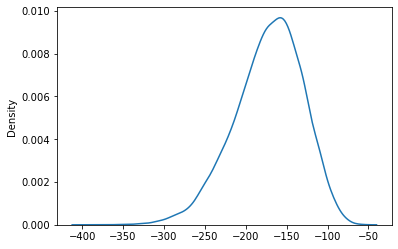

In [ ]:
sns.kdeplot(mix_weights_M.numpy())

In [ ]:
split_joints = mix_weights_M[None, :, None] + predictions_N_M_C[55:]  # [:, mix_weights_M > -40, :]

In [ ]:
# predictions_N = torch.argmax(torch.logsumexp(split_joints, dim=1), dim=1)
predictions_N = torch.argmax(torch.sum(split_joints.exp(), dim=1), dim=1)
# predictions_N = torch.argmax(torch.log_softmax(torch.logsumexp(split_joints, dim=1), dim=1), dim=1)

In [ ]:
predictions_N.shape

torch.Size([10000])

In [ ]:
sum(predictions_N == labels_N[55:]) / len(predictions_N)

tensor(0.7097)

# Prior Sampling

In [ ]:
# Cell
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn
import torch.optim
from torch import nn as nn
from torch.nn import Module
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from batchbald_redux.active_learning import RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import train
from batchbald_redux.consistent_mc_dropout import (
    BayesianModule,
    ConsistentMCDropout,
    ConsistentMCDropout2d,
    GradEmbeddingType,
    freeze_encoder_context,
)
from batchbald_redux.model_optimizer_factory import (
    ModelOptimizer,
    ModelOptimizerFactory,
)

# Cell
from batchbald_redux.trained_model import (
    ModelTrainer,
    TrainedBayesianModel,
    TrainedModel,
)


class MNISTCNN(BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor, freeze_encoder: bool):
        with freeze_encoder_context(freeze_encoder):
            input = F.relu(F.max_pool2d(self.conv1(input), 2))
            input = F.relu(F.max_pool2d(self.conv2(input), 2))
            input = input.view(-1, 1024)
            input = F.relu(self.fc1(input))

        embedding = input
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input, embedding

In [ ]:
# Cell
from contextlib import nullcontext
from dataclasses import dataclass
from enum import Enum
from functools import wraps
from typing import List

import numpy as np
import torch
from blackhc.progress_bar import create_progress_bar
from toma import toma
from torch.nn import Module
# Cell
from torch.utils import data


def assert_no_shuffling_no_augmentations_dataloader(dataloader: data.DataLoader):
    batch_x_A = None
    batch_labels_A = None
    batch_x_B = None
    batch_labels_B = None

    for batch_x_A, batch_labels_A in dataloader:
        break

    for batch_x_B, batch_labels_B in dataloader:
        break

    assert torch.all(
        batch_x_A == batch_x_B
    ), "Batch inputs different. Augmentations enabled, or dataloader shuffles data?!"


    assert torch.all(batch_labels_A == batch_labels_B), "Batch labels different. Augmentations enabled, or dataloader shuffles data?!"

    
@torch.no_grad()
def reinit_model_get_predictions_labels(
    model_class: Type, *, num_samples: int, loader: data.DataLoader, device, storage_device
):
    assert_no_shuffling_no_augmentations_dataloader(loader)
    assert num_samples > 0

    N = len(loader.dataset)
    predictions = None
    labels = None

    pbar = create_progress_bar(N * num_samples, tqdm_args=dict(desc="get_predictions_labels", leave=False))
    pbar.start()

    @toma.execute.range(0, num_samples, 1)
    def get_prediction_batch(start, end):
        nonlocal predictions
        nonlocal labels

        if start == 0:
            predictions = None
            labels = None
            pbar.reset()

        num_sub_samples = end - start

        data_start = 0
        for batch_x, batch_labels in loader:
            batch_x = batch_x.to(device=device, non_blocking=True)
            
            model = model_class()
            model.to(device=device)
            model.eval()
            batch_predictions = model(batch_x, 1)

            batch_size = len(batch_predictions)
            data_end = data_start + batch_size

            # Support multi-dim predictions.
            if predictions is None:
                predictions_shape = (N, num_samples, *batch_predictions.shape[2:])
                predictions = torch.empty(predictions_shape, dtype=batch_predictions.dtype, device=storage_device)
            # Support multi-dim labels.
            if labels is None:
                labels_shape = (N, *batch_labels.shape[1:])
                labels = torch.empty(labels_shape, dtype=batch_labels.dtype, device=storage_device)

            predictions[data_start:data_end, start:end].copy_(batch_predictions, non_blocking=True)
            if start == 0:
                labels[data_start:data_end].copy_(batch_labels, non_blocking=True)

            data_start = data_end

            pbar.update(batch_size * num_sub_samples)

    pbar.finish()

    return predictions, labels

In [ ]:
predictions_N_M_C, labels_N = reinit_model_get_predictions_labels(
    MNISTCNN, num_samples=100, loader=joint_loader, device="cuda", storage_device="cpu"
)

get_predictions_labels:   0%|          | 0/1005500 [00:00<?, ?it/s]

In [ ]:
virtual_training_set_size = 50  # len(training_set_90)

In [ ]:
true_train_predictions_n_M = predictions_N_M_C[
    list(range(virtual_training_set_size)), :, labels_N[:virtual_training_set_size]
]

In [ ]:
true_train_predictions_n_M.shape

torch.Size([50, 100])

In [ ]:
mix_weights_M = torch.sum(true_train_predictions_n_M, dim=0) / (virtual_training_set_size / 40)

In [ ]:
mix_weights_M.shape

torch.Size([100])

In [ ]:
mix_weights_M

tensor([-93.7274, -92.3730, -93.3257, -91.8971, -93.8792, -91.4355, -91.9618,
        -91.4423, -92.1715, -92.9064, -92.6598, -92.2078, -91.6831, -91.3584,
        -93.7402, -91.9232, -92.2881, -92.1177, -93.3058, -92.1556, -92.6762,
        -91.8038, -91.6045, -91.4175, -91.6196, -93.0117, -92.9579, -92.6618,
        -93.0963, -91.6542, -92.2731, -92.0759, -93.4786, -91.4171, -91.0366,
        -91.8476, -92.0384, -91.8310, -93.4134, -91.3530, -92.2231, -93.8096,
        -92.9808, -93.4071, -92.2301, -92.4571, -90.6741, -92.9026, -91.6518,
        -92.1958, -92.3968, -92.5815, -92.6207, -92.3945, -93.0710, -93.0059,
        -92.5404, -92.4819, -91.7358, -91.9300, -92.0748, -91.9805, -92.0914,
        -91.6912, -92.9176, -91.7888, -92.1684, -92.1748, -92.5272, -91.5815,
        -91.3627, -92.4682, -92.4429, -92.1385, -92.1866, -92.6167, -93.1052,
        -91.1981, -92.6332, -92.6460, -91.6807, -92.7387, -91.6578, -92.4994,
        -92.3912, -92.1155, -92.2767, -91.4916, -93.1281, -91.99

<AxesSubplot:ylabel='Density'>

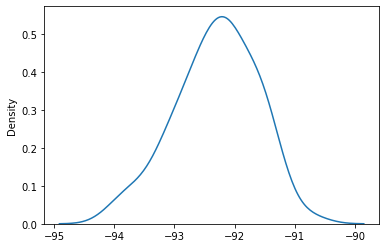

In [ ]:
sns.kdeplot(mix_weights_M.numpy())

In [ ]:
split_joints = mix_weights_M[None, :, None] + predictions_N_M_C[virtual_training_set_size:]

In [ ]:
# predictions_N = torch.argmax(torch.logsumexp(split_joints, dim=1), dim=1)
predictions_N = torch.argmax(torch.sum(split_joints.exp(), dim=1), dim=1)
# predictions_N = torch.argmax(torch.log_softmax(torch.logsumexp(split_joints, dim=1), dim=1), dim=1)

In [ ]:
predictions_N.shape

torch.Size([10005])

In [ ]:
sum(predictions_N == labels_N[virtual_training_set_size:]) / len(predictions_N)

tensor(0.1070)